# **Racing Data Analysis Project**

## **Project Goal**
To determine the most optimal car for participating in GT World Challenge Europe races that provides the highest and most consistent results across all tracks in the championship. To achieve this, the project identifies which cars were dominant in the last three seasons (2021, 2022, and 2023) and which cars were dominant on each specific track during the 2023 season.

## **1. Methodology**

### **1.1. Accrual of Points**

Points are awarded to the top 10 finishers in each race using the following system:

- 1st place: 10 points + 3 bonus points = 13 points total
- 2nd place: 9 points + 2 bonus points = 11 points total
- 3rd place: 8 points + 1 bonus point = 9 points total
- 4th place: 7 points
- 5th place: 6 points
- 6th place: 5 points
- 7th place: 4 points
- 8th place: 3 points
- 9th place: 2 points
- 10th place: 1 point

### **1.2. Weighing and Normalizing Points**

In the GT World Challenge Europe championships, different tracks can host a varying number of races, each with different durations.

#### **1.2.1. Weighing by Race Duration**

Points are adjusted by a coefficient directly proportional to the race duration:

- Define the base race length as 50 laps.
- For each race, points are multiplied by the ratio that is directly proportional to the duration of the race.
- A win is worth 13 points in a 50-lap race. In a 64-lap race, the points for a win would be adjusted to $13\times(\frac{64}{50}) = 16.64$ points.

#### **1.2.2. Normalizing by Number of Races**

Total points scored by a race car at each track are divided by the number of races held there:

- Example: If the Mercedes-AMG GT3 scores 60 points at Barcelona over 3 races, the normalized score would be 60 / 3 = 20 points.

### **1.3. Identifying Leaders**

#### **1.3.1. Leaders by Season**

- Median positions are calculated for each car across all tracks for a season.
- The car with the lowest median position is designated as the season leader, showcasing consistent high performance.

#### **1.3.2. Leaders by Specific Race Track**

- Points are aggregated for each car at individual tracks.
- The car with the highest total points at a specific track is recognized as the track leader.

### **1.4. Data Visualization**

The results will be presented in the form of visualizations for better understanding.

## **2\. Load Libraries**

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **3\. Load Data**

In [122]:
df = pd.read_parquet(".\\cleaned_data\\race_data.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7319 entries, 0 to 7318
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   Season                7319 non-null   int64          
 1   Meeting               7319 non-null   object         
 2   Event name            7319 non-null   object         
 3   Pos                   7319 non-null   int64          
 4   Car #                 7319 non-null   int64          
 5   Class                 7319 non-null   category       
 6   Special Class         7319 non-null   bool           
 7   Drivers               7319 non-null   object         
 8   Team                  7319 non-null   object         
 9   Car                   7319 non-null   object         
 10  Best lap set          7319 non-null   bool           
 11  Time                  7319 non-null   object         
 12  Time timedelta        7319 non-null   timedelta64[ns]
 13  Lap

## **4\.'Points' column**
### **4.1. Add weighted 'Points' column**

In [123]:
# Definition of the point system
points_system = {1: 13, 2: 11, 3: 9, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}

# Function to assign points based on position
def assign_points(pos, laps, weighted, directly_proportional, base_laps=50):
    base_points = points_system.get(pos, 0)
    if weighted == False:
        return base_points
    else:
        if directly_proportional == True:
            # Will give points directly proportional to the duration of the race.
            lap_factor = base_laps / laps
        else:
            # Will give points inversely proportional to the duration of the race.
            lap_factor = laps / base_laps
        return base_points * lap_factor

# Adding a 'Points' column to the DataFrame
df['Points'] = df.apply(lambda row: assign_points(row['Pos'], row['Laps'], weighted = True, directly_proportional = True), axis=1)

### **4.2. Normalizing the 'Points' column**

In [124]:
def normalizing_points(df, column_name, sum_points=True):
    normalized_points = pd.DataFrame()

    # Retrieving unique meetings and seasons
    unique_meetings = df['Meeting'].unique()
    unique_seasons = df['Season'].unique()

    # Looping through all seasons and meetings to handle points
    for season in unique_seasons:
        for meeting in unique_meetings:
            # Filtering data for a specific meeting and season
            filtered_data = df[(df['Meeting'] == meeting) & (df['Season'] == season)]

            if not filtered_data.empty:
                if sum_points:
                    # Summing points by car, sort, and reset index
                    points_by_car = filtered_data.groupby('Car')[column_name].sum().reset_index()
                else:
                    # Just use the filtered data without summing or normalizing
                    points_by_car = filtered_data[['Car', column_name]].copy()

                points_by_car.sort_values(by=column_name, ascending=False, inplace=True)
                points_by_car['Meeting'] = meeting
                points_by_car['Season'] = season
                points_by_car['Pos'] = points_by_car[column_name].rank(method='min', ascending=False).astype(int)

                # Ensuring all necessary columns are present
                columns_to_keep = ['Car', column_name, 'Meeting', 'Season', 'Pos']
                points_by_car = points_by_car[columns_to_keep]

                # Appending to the main dataframe
                normalized_points = pd.concat([normalized_points, points_by_car], ignore_index=True)

    return normalized_points


# Displaying the final dataframe
normalized_points_sum = normalizing_points(df, 'Points', True)
normalized_points_sum = normalized_points_sum[normalized_points_sum['Points'] > 0]
normalized_points_sum.head()

,Car,Points,Meeting,Season,Pos
0,Mercedes-AMG GT3,46.373030,Barcelona,2021,1
1,Porsche 911 GT3-R (991.II),32.910985,Barcelona,2021,2
2,Lamborghini Huracan GT3 EVO,19.325892,Barcelona,2021,3
3,Ferrari 488 GT3,17.372636,Barcelona,2021,4
4,Audi R8 LMS GT3,14.269263,Barcelona,2021,5


## **5. Identification of Leaders**

Let's create several functions for plotting to eliminate the repetitive code.

In [133]:
# Adding specific color for each Manufacturer
colors ={
    'Aston Martin Vantage AMR GT3' : '#004225',
    'Aston Martin Vantage GT3': '#004225',
    'Bentley Continental GT3': '#0d8f52',
    'Audi R8 LMS GT3': '#8a8d8f', 
    'Audi R8 LMS GT3 EVO 2': '#8a8d8f',
    'BMW M4 GT3': '#81c4ff',
    'BMW M6 GT3': '#81c4ff',
    'Ferrari 296 GT3': '#d40000', 
    'Ferrari 488 GT3': '#d40000', 
    'Honda NSX GT3': '#292828',
    'Honda NSX GT3 EVO 2': '#292828', 
    'Lamborghini Huracan GT3 EVO': '#afe301', 
    'Lamborghini Huracan GT3 EVO 2': '#afe301',
    'McLaren 720S GT3': '#ff8000',
    'McLaren 720S GT3 EVO': '#ff8000',
    'Mercedes-AMG GT3': '#03bfb5',
    'Mercedes-AMG GT3 EVO': '#03bfb5',
    'Mercedes-AMG GT3 2020': '#03bfb5', 
    'Porsche 911 GT3 R (992)': '#B30838', 
    'Porsche 911 GT3-R (991.II)': '#B30838'
}


# Function to plot summary graph to identify season(s) leaders
def plot_summary(data, title_suffix):
    summary_data = data.groupby('Car')['Pos'].median().sort_values().reset_index()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(x='Pos', y='Car', data=summary_data, hue='Car', palette=colors, ax=ax, legend=False)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_title(f'Summary of Best Cars by Median Position - {title_suffix}')
    adjust_text_positions(ax, summary_data['Pos'])
    plt.show()

# Function to plot result on individal track
def plot_individual_track(data, ax=None, title=""):
    # Create a new chart if ax is not provided
    if ax is None:
        fig, ax = plt.subplots()

    sns.barplot(x='Points', y='Car', data=data, hue='Car', palette=colors, ax=ax, legend=False)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title)
    adjust_text_positions(ax, data['Points'])  # Предполагается, что это ваша кастомная функция

    # Show a graph if the function is called separately
    if ax is None:
        plt.show()

# Function for adjusting text positions to improve readability.
def adjust_text_positions(ax, points):
    max_points = points.max()
    ax.set_xlim(0, max_points * 1.20)  # Increase maximum 20% for text
    
    for i, point in enumerate(points):
        x_position = point + max_points * 0.02  # small indentation on the right
        if x_position > ax.get_xlim()[1]:
            x_position = point - max_points * 0.02
            ha = 'right'
        else:
            ha = 'left'
        ax.text(x_position, i, f'{point:.1f}', color='black', va='center', ha=ha)

# Function for plotting a summary graph for all seasons.
def median_of_medians(df, title_suffix):
    # Группируем данные по машинам и сезонам, вычисляем медиану позиций для каждого сезона
    season_medians = df.groupby(['Car', 'Season'])['Pos'].median().reset_index()

    # Группируем полученные медианные значения по машинам и вычисляем медиану этих медиан
    final_medians = season_medians.groupby('Car')['Pos'].median().sort_values().reset_index()

    return plot_summary(final_medians, title_suffix)



# Function to plot all results on all tracks in race season(s)
def plot_tracks(df, season, summary=False):

    if season == "All":
        data = df
        title_suffix = "Seasons 2021, 2022 and 2023"
    else:
        data = df[(df['Season'] == season) & (df['Points'] > 0)]
        title_suffix = f"Season {season}"

    if summary:
        # Summary graph for all seasons
        if season == "All":
            median_of_medians(data, title_suffix)
        else:
            # Summary graph for all tracks in the selected season
            plot_summary(data, title_suffix)
    else:
        # Graphs for each track in the season
        unique_meetings = data['Meeting'].unique()
        num_meetings = len(unique_meetings)
        fig, axes = plt.subplots(nrows=(num_meetings + 1) // 2, ncols=2, figsize=(15, 8 * num_meetings // 2))
        axes = axes.flatten()
        
        for i, meeting in enumerate(unique_meetings):
            meeting_data = data[data['Meeting'] == meeting]
            plot_individual_track(meeting_data, axes[i], title=f'{meeting} - {title_suffix}')
        
        # Remove empty subgraphs if they exist
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()

### **5.1 Leadrs by Season**

#### **5.1.1. Leaders by median positions for last 3 seasons (2021, 2022 and 2023)**

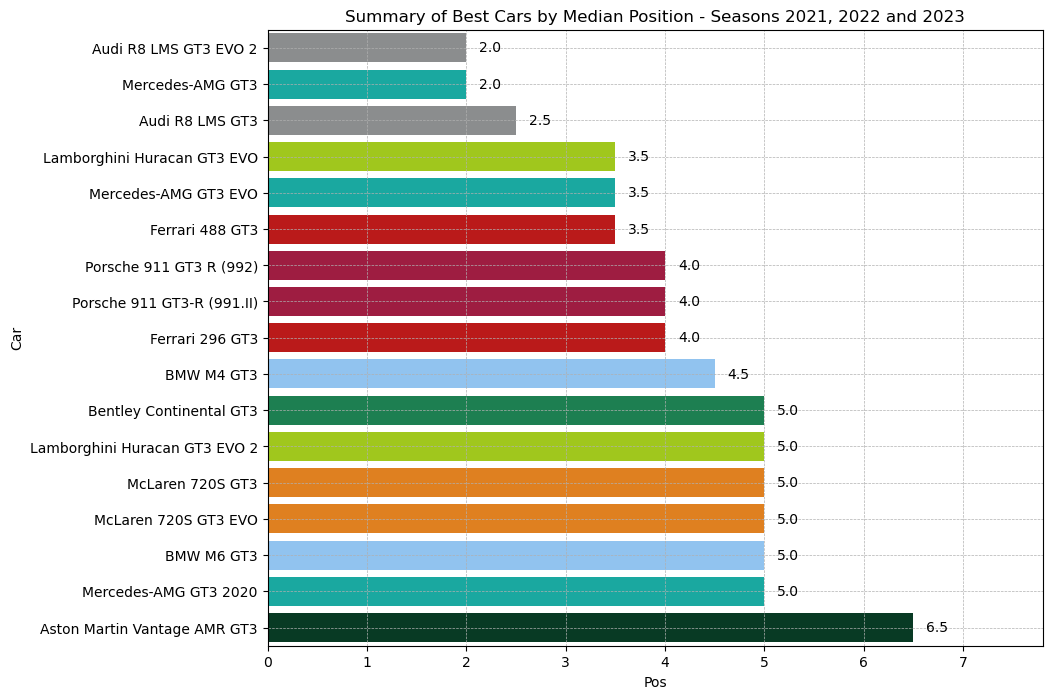

In [135]:
plot_tracks(normalized_points_sum, 'All', summary=True)

#### **5.1.2. Leaders by median position for the 2021 season**

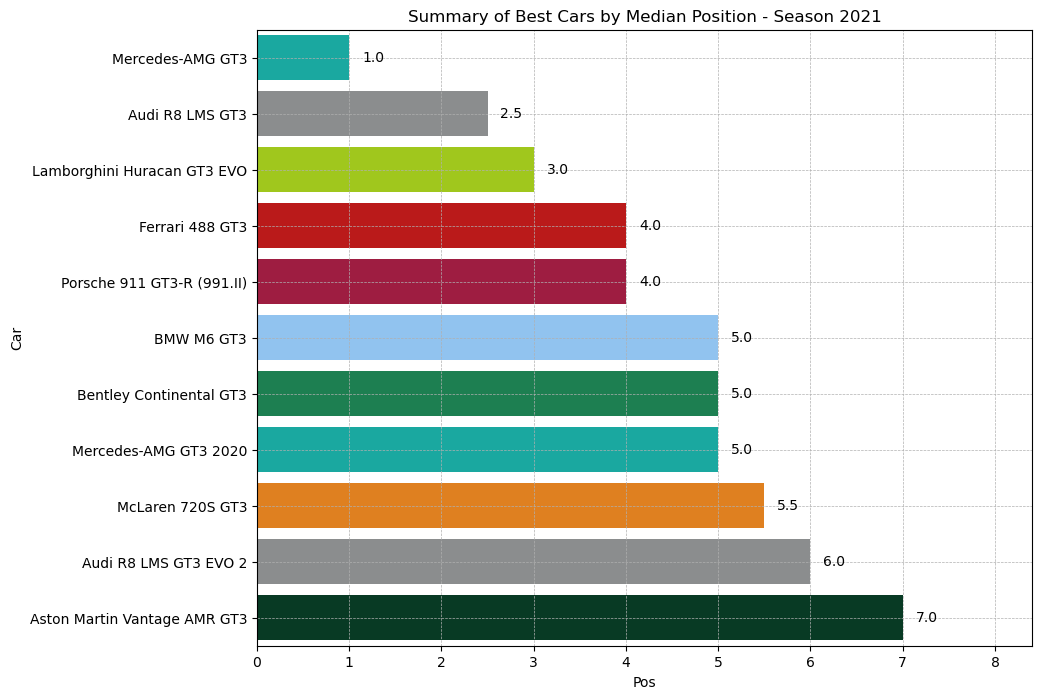

In [127]:
plot_tracks(normalized_points_sum, 2021, summary=True)

#### **5.1.3. Leaders by median position for the 2022 season**

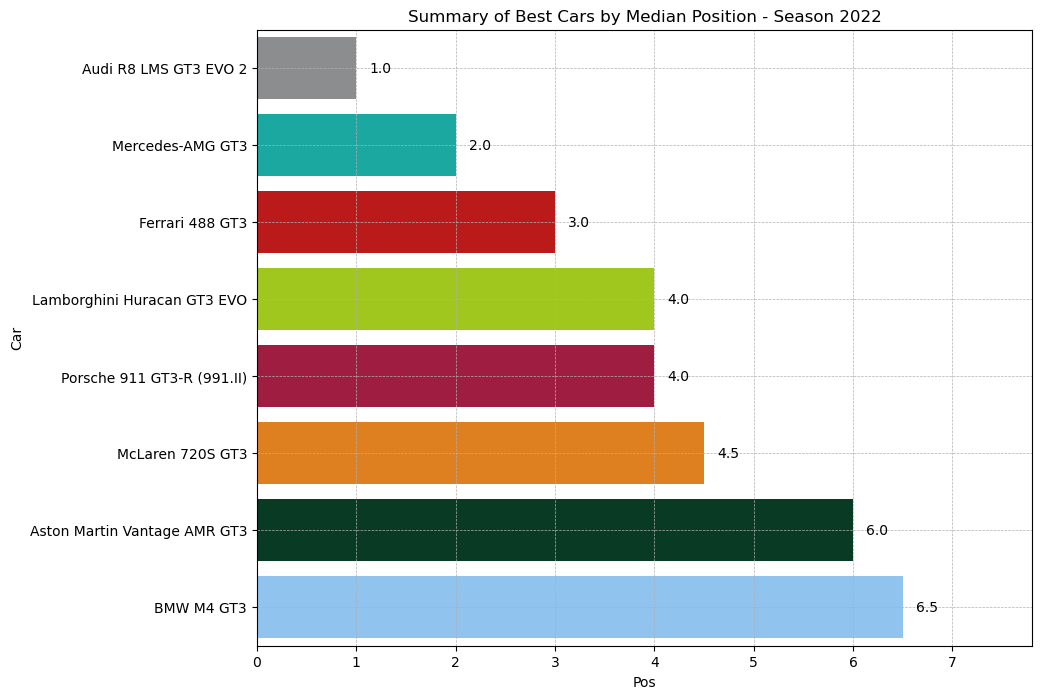

In [128]:
plot_tracks(normalized_points_sum, 2022, summary=True)

#### **5.1.4. Leaders by median position for the 2023 season**

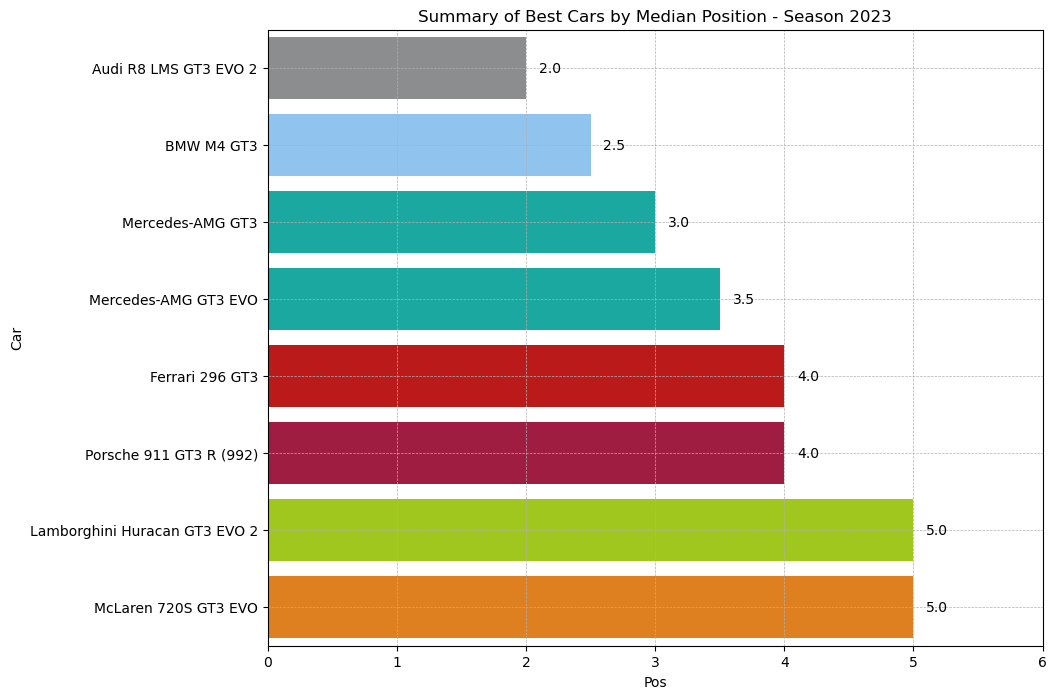

In [129]:
plot_tracks(normalized_points_sum, 2023, summary=True)

### **5.2. Leaders at a specific race track for the 2023 season**

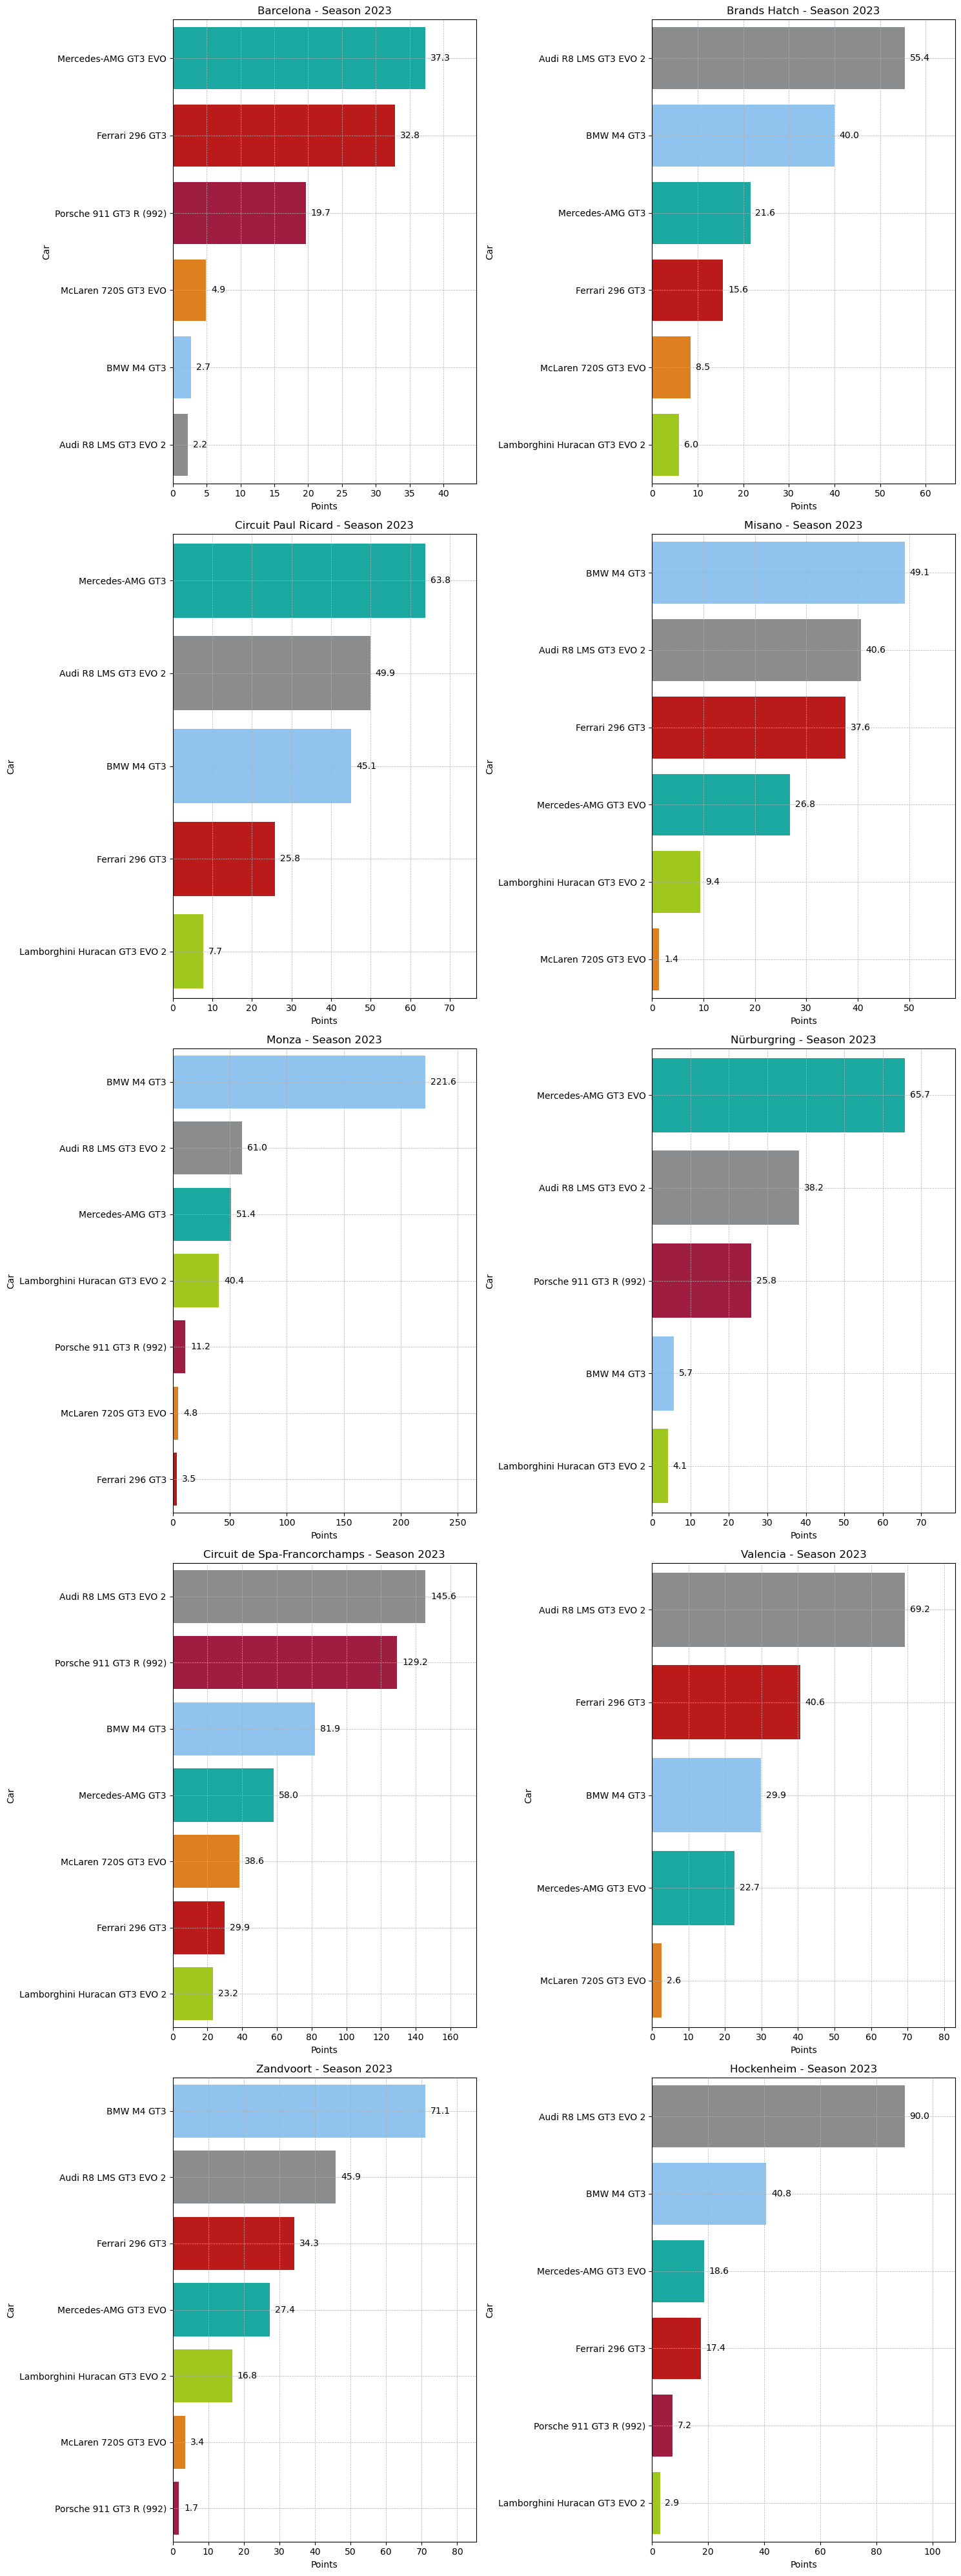

In [130]:
plot_tracks(normalized_points_sum, 2023)  

## **6. Conclusion**

Overall leaders:
1. The most successful cars over the last three seasons (2021, 2022, and 2023) are the `Audi R8 LMS GT3 EVO 2` and the `Mercedes-AMG GT3`, both achieving a median finish position of **2.0**. 
2. In third place is the `Audi R8 LMS GT3` with a median finish position of **2.5**.

Leaders for season 2021:
1. The most successful car is the `Mercedes-AMG GT3` with a strong lead from second place, achieving a median finish position of **1.0**.
2. In second position is the `Audi R8 LMS GT3` with a median finish position of **2.5**.
3. In third place is the `Audi R8 LMS GT3` with a median finish position of **3.0**.

Leaders for season 2022:
1. The most successful car is the `Audi R8 LMS GT3 EVO 2` with a strong lead, achieving a median finish position of **1.0**.
2. In second position is the `Mercedes-AMG GT3` with a median finish position of **2.0**.
3. In third place is the `Ferrari 488 GT3` with a median finish position of **3.0**.

Leaders for season 2023:
In this season, the competition was more even.
1. The most successful car is the `Audi R8 LMS GT3 EVO 2`, achieving a median finish position of **2.0**.
2. In second position is the `BMW M4 GT3` with a median finish position of **2.5**.
3. In third place is the `Mercedes-AMG GT3` with a median finish position of **3.0**.



Leaders at a specific race track during the 2023 season:

Barcelona:
In Barcelona, we can observe an outstanding group of cars. First and second places are close to each other, while third place has a significant lag behind second place.
1. `Mercedes-AMG GT3 EVO` in first place with points equal to **37.3**.
2. `Ferrari 296 GT3` in second place with points equal to **32.8**.
3. `Porsche 911 GT3 R (992)` in third place with points equal to **19.7**.

Brands Hatch:
In Brands Hatch we can observe the clear dominance of first position, second position also showing strong competitiveness, while third place almost twice behind second place.
1. `Audi R8 LMS GT3 EVO 2` in first place with points equal to **55.4**.
2. `BMW M4 GT3` in second place with points equal to **40.0**.
3. `Mercedes-AMG GT3` in third place with points equal to **21.6**.

Circuit Paul Ricard:
In Circuit Paul Ricard we can observe an outstanding group of cars. First place with clear dominance, while second and third place much closer to each other.
1. `Mercedes-AMG GT3` in first place with points equal to **63.8**.
2. `Audi R8 LMS GT3 EVO 2` in second place with points equal to **49.9**.
3. `BMW M4 GT3` in third place with points equal to **45.1**.

Misano
